In [1]:
%run Financial_data.ipynb

/Users/alexanderjarvheden/Projects/FearGreed-rebalancingPortfolioModel/FGI/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/6h/tflctw7s3jb8k6w65jmxt4440000gn/T/ipykernel_6805/1711228976.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPY_FGI'] = df['rating'].map(rating_map)
/var/folders/6h/tflctw7s3jb8k6w65jmxt4440000gn/T/ipykernel_6805/1711228976.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

SPY historical data
BND historical data
GLD historical data
hodl historical data
hello man
[INFO] Trained regressor — Test MSE: 0.000300
           Date  FGI      Close  Change %
669  2025-01-10    2  18.340500  0.771973
670  2025-01-13    3  17.916000 -1.452682
671  2025-01-14    3  18.602699 -0.271806
672  2025-01-15    3  19.548800  2.942600
673  2025-01-16    3  19.972200  1.948396
674  2025-01-17    3  20.603600  1.394174
675  2025-01-21    4  20.292700  1.944162
hello man
DEBUG — amount_pct: -0.001009165309369564 | mu_view: -0.0010086564443825658 | confidence: 0.055034795243107115
-0.0010086564443825658 0.055034795243107115
hello man
[INFO] Trained regressor — Test MSE: 0.000006
hello man
DEBUG — amount_pct: -6.430789653677493e-05 | mu_view: -6.430582887264072e-05 | confidence: 0.026534103878116916
-6.430582887264072e-05 0.026534103878116916
hello man
[INFO] Trained regressor — Test MSE: 0.000076
hello man
DEBUG — amount_pct: 0.00033135246485471725 | mu_view: 0.000331297579750609

In [2]:
# ────────────────────────────────────────────────────────────────
#  BLACK-LITTERMAN: bygg views från färdiga matriser (weekly)
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import risk_models, black_litterman, BlackLittermanModel, EfficientFrontier


# ▸ 0. SÄKERHETSKOLL  --------------------------------------------------


# missing = [name for name in needed if name not in globals()]
# if missing:
#     raise RuntimeError(
#         f"Variabler saknas i minnet: {missing}. "
#         "Kör först financial_data.ipynb så att de skapas."
#     )

# ▸ 1. SKAPA closing_prices-matris från dina DataFrames  --------------
def to_series(df, name):
    s = df.set_index("Date")["Close"]
    s.index = pd.to_datetime(s.index)
    return s.rename(name)

closing_prices = pd.concat(
    [
        to_series(df_bnd,  "BND"),
        to_series(df_gld,  "GLD"),
        to_series(df_hodl, "HODL.PA"),
        to_series(df_spy,  "SPY"),
    ],
    axis=1,
).sort_index()
closing_prices = closing_prices.dropna()
closing_prices


,BND,GLD,HODL.PA,SPY
Date,,,,
2022-05-05,68.762268,175.130005,15.0100,396.066406
2022-05-06,68.471077,175.419998,15.0100,393.702271
2022-05-09,68.780441,172.880005,9.9000,381.097046
2022-05-10,68.980629,171.419998,9.8700,381.977539
2022-05-11,69.217216,172.820007,9.8700,375.909393
...,...,...,...,...
2025-04-23,72.529999,303.649994,13.7177,535.419983
2025-04-24,72.940002,308.070007,13.8389,546.690002
2025-04-25,73.180000,304.730011,14.1237,550.640015


OrderedDict([('BND', 0.66508), ('GLD', 0.10597), ('HODL.PA', 0.01294), ('SPY', 0.21601)])
Views: {'SPY': np.float64(0.0003312975797506096), 'BND': np.float64(-6.430582887264072e-05), 'GLD': np.float64(-6.60311006445036e-05), 'HODL.PA': np.float64(-0.0010086564443825658)}
Conf: [np.float64(0.03668688265151542), np.float64(0.026534103878116916), np.float64(0.011243029921858263), np.float64(0.055034795243107115)]

OPTIMERAD PORTFÖLJ (weekly BL):
  BND    :  66.5 %
  GLD    :  10.6 %
  HODL.PA:   1.3 %
  SPY    :  21.6 %


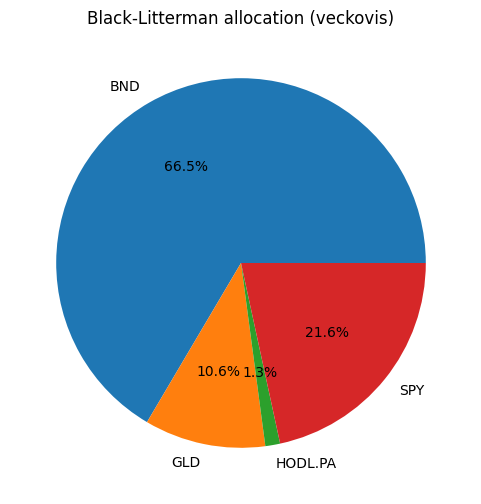

In [3]:
mcaps = {
    "SPY": 46_483_000_000_000, 
    "BND": 140_700_000_000_000,
    "GLD":  22_335_000_000_000,
    "HODL.PA": 2_970_000_000_000,
}
cov   = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(closing_prices["SPY"])
pi    = black_litterman.market_implied_prior_returns(mcaps, delta, cov)

bl = BlackLittermanModel(
    cov,
    pi=pi,
    absolute_views=viewdict,
    omega="idzorek",
    view_confidences=confidences,
    risk_aversion=delta,
)
ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
ef.max_sharpe()
weights = ef.clean_weights()

print(weights)

print("Views:", viewdict)
print("Conf:", confidences)

print("\nOPTIMERAD PORTFÖLJ (weekly BL):")
for k, v in weights.items():
    print(f"  {k:7s}: {v*100:5.1f} %")

# (valfritt) visa fördelningen
pd.Series(weights).plot.pie(figsize=(6,6), autopct='%1.1f%%')
plt.ylabel("")
plt.title("Black-Litterman allocation (veckovis)")
plt.show()


In [4]:
from xgb import Trainer
closing_prices = closing_prices.reset_index()
closing_prices['Date'] = closing_prices['Date'].dt.strftime('%Y-%m-%d')  # Ensure same format
closing_prices = pd.merge(closing_prices, df_bnd_ml, on=['Date', 'Date'])

n = int(0.8*len(closing_prices.values))

ASSETS = [df_bnd_ml, df_gld_ml, merged2, df_spy_ml]

bnd_trainer = Trainer().fit(df_bnd_ml)
gld_trainer = Trainer().fit(df_gld_ml)
crypto_trainer = Trainer().fit(merged2)
spy_trainer = Trainer().fit(df_spy_ml)

trainers = [bnd_trainer, gld_trainer, crypto_trainer, spy_trainer]
tickers = ["BND", "GLD", "HODL.PA", "SPY"]

returns = 1
benchmark = 1 + (
    (closing_prices["SPY"].iloc[len(closing_prices.values)-1] - closing_prices["SPY"].iloc[n]) / closing_prices["SPY"].iloc[n] * 0.6
    +(closing_prices["BND"].iloc[len(closing_prices.values)-1] - closing_prices["BND"].iloc[n]) / closing_prices["BND"].iloc[n] * 0.4
    )

print("Investment period starts at: ", closing_prices['Date'].iloc[n])
for date in range(n, len(closing_prices.values)):
    views, confidences = {}, []
    for i, etf in enumerate(ASSETS):
        mu, conf = trainers[i].predict(etf.iloc[date-8:date])
        views[tickers[i]] = mu
        confidences.append(conf)
    bl = BlackLittermanModel(
        cov,
        pi=pi,
        absolute_views=views,
        omega="idzorek",
        view_confidences=confidences,
        risk_aversion=delta,
    )
    ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
    ef.max_sharpe()
    weights = ef.clean_weights()
    returns += sum([((closing_prices[etf].iloc[date] - closing_prices[etf].iloc[date - 1]) / closing_prices[etf].iloc[date - 1]) * weight for etf, weight in weights.items()])

print("Portfolio returns was: ", returns)
print("Benchmark was: ", benchmark)
    

hello man
[INFO] Trained regressor — Test MSE: 0.000006
hello man
[INFO] Trained regressor — Test MSE: 0.000034
hello man
[INFO] Trained regressor — Test MSE: 0.000300
hello man
[INFO] Trained regressor — Test MSE: 0.000076
Investment period starts at:  2024-07-25
hello man
DEBUG — amount_pct: -6.430789653677493e-05 | mu_view: -6.430582887264072e-05 | confidence: 0.026534103878116916
hello man
DEBUG — amount_pct: -6.603328074561432e-05 | mu_view: -6.60311006445036e-05 | confidence: 0.011243029921858263
hello man
DEBUG — amount_pct: -0.001009165309369564 | mu_view: -0.0010086564443825658 | confidence: 0.055034795243107115
hello man
DEBUG — amount_pct: 0.00033135246485471725 | mu_view: 0.0003312975797506096 | confidence: 0.03668688265151542
hello man
DEBUG — amount_pct: -6.430789653677493e-05 | mu_view: -6.430582887264072e-05 | confidence: 0.026534103878116916
hello man
DEBUG — amount_pct: -6.603328074561432e-05 | mu_view: -6.60311006445036e-05 | confidence: 0.011243029921858263
hello ma